# the code below gives Real and Imaginary parts of a complex pole of a complex function.
For more context see https://arxiv.org/pdf/2408.08954 Figure S12

In [94]:
import numpy as np

"""
Functions for pole evaluation
"""

def eval_poles(k_val, mu, dimensions=3, alpha_max=25, k_val_cutoff=1e10):
    r"""
    eval_poles - Evaluate the poles for the wormlike chain Green's function for a given :math:`K`
    and :math:`z`-component quantum index :math:`\mu`

    Parameters
    ----------

    k_val : float
        The value of the Fourier vector magnitude :math:`K`
    mu : int
        Value of the mu parameter
    dimensions : int
        The number of dimensions (default to 3 dimensions)
    alpha_max : int
        Maximum number of poles evaluated (default 25)
    k_val_cutoff : float
        Cutoff value of :math:`K` for crossover from intermediate-k algorithm to large-k algorithm
        
        Comment: Remove the k_val_cutoff from later algorithms so everything is calculated exactly

    Returns
    -------
    poles : complex float
        Evaluated poles for the given :math:`K` and :math:`\mu`

    """

    # Use the intermediate-k or large-k algorithm based on k_val_cutoff
    if abs(k_val) < k_val_cutoff:
        poles = eval_poles_intermediate_k_val(k_val, mu, dimensions, alpha_max)
    else: 
        #do not ever use this part of the algorithm
        #poles = eval_poles_large_k_val(k_val, mu, dimensions, alpha_max)
        print("high-k algorithm not available")

    return poles


def eval_poles_intermediate_k_val(k_val, mu, dimensions=3, alpha_max=25):
    r"""
    eval_poles_intermediate_k_val - Evaluate the poles for given :math:`K` and :math:`\mu`
    using the matrix method for intermediate :math:`K`

    Parameters
    ----------
    k_val : float
        The value of the Fourier vector magnitude :math:`K`
    mu : int
        Value of the mu parameter
    dimensions : int
        The number of dimensions (default to 3 dimensions)
    alpha_max : int
        Maximum number of poles evaluated (default 25)

    Returns
    -------
    poles : complex float
        Evaluated poles for the given :math:`K` and :math:`\mu` using the intermediate-k algorithm

    """

    # Determine the number of poles evaluated noting conjugate pairing
    # Evaluate 4 times the number needed to achieve accuracy

    num_total = int(4 * 2 * (np.ceil(alpha_max / 2.0)))  # Eigenvalues come in pairs

    # Build the h-matrix used to evaluate the poles of the Green function
    lam = mu + np.arange(0, num_total)
    if k_val <= 1:
        diagonal = lam * (lam + dimensions - 2)
        diagonal_plus1 = -1j * k_val * eval_a_lam_mu(lam[1:num_total], mu, dimensions)
        h_matrix = np.diag(diagonal) + np.diag(diagonal_plus1, 1) + np.diag(diagonal_plus1, -1)
    else:
        diagonal = lam * (lam + dimensions - 2) / k_val
        diagonal_plus1 = -1j * eval_a_lam_mu(lam[1:num_total], mu, dimensions)
        h_matrix = np.diag(diagonal) + np.diag(diagonal_plus1, 1) + np.diag(diagonal_plus1, -1)

    # Find the poles as the eigenvalues of the h-matrix
    poles_total = -1 * np.linalg.eigvals(h_matrix)
    poles_total = np.sort(poles_total)[::-1]

    # Fix sorting
    for ii in range(0, (num_total - 1), 2):
        poles_total[ii] = np.real(poles_total[ii]) + 1j * abs(np.imag(poles_total[ii]))
        poles_total[ii + 1] = np.real(poles_total[ii + 1]) - 1j * abs(np.imag(poles_total[ii + 1]))

    if k_val > 1:
        poles_total = poles_total * k_val

    poles = poles_total[0:(alpha_max - abs(mu) + 1)]

    return poles


def eval_poles_large_k_val(k_val, mu, dimensions=3, alpha_max=25):
    r"""
    eval_poles_large_k_val - Evaluate the poles for given :math:`K` and :math:`\mu`
    using the expansion method (perturbation theory) for large :math:`K`

    Parameters
    ----------
    k_val : float
        The value of the Fourier vector magnitude :math:`K`
    mu : int
        Value of the mu parameter
    dimensions : int
        The number of dimensions (default to 3 dimensions)
    alpha_max : int
        Maximum number of poles evaluated (default 25)

    Returns
    -------
    poles : complex float
        Evaluated poles for the given :math:`K` and :math:`\mu` using the large-k algorithm
    """

    poles_total = np.zeros(alpha_max + 1, dtype='complex') * np.NaN
    for l_val in range(0, alpha_max, 2):
        poles_total[l_val] = 1j * k_val - mu * (mu + dimensions - 2) - eval_epsilon(l_val / 2.0, dimensions, k_val, mu)
        poles_total[l_val + 1] = np.conj(poles_total[l_val])

    poles = poles_total[0:(alpha_max - abs(mu) + 1)]

    return poles


"""
Functions for residue evaluation
"""

def eval_residues(k_val, mu, poles=None, lam_zero_only=True, dimensions=3, lam_max=25, alpha_max=25,
                  lam_cont_frac_max=500, k_val_cutoff=10 ** -2):
    r"""

    eval_residues - Evaluate the residues for the wormlike chain Green's function for a given :math:`K`
    and :math:`z`-component quantum index :math:`\mu`

    Parameters
    ----------

    k_val : float
        The value of the Fourier vector magnitude :math:`K`
    mu : int
        Value of the mu parameter
    poles : complex float array (length [alpha_max + 1])
        Values of the poles for a given :math:`K` and :math:`\mu` (default to None)
    lam_zero_only : boolean
        Indicates whether the residues will be evaluated over the range of :math:`\lambda` and :math:`lambda_{0}`
    dimensions : int
        The number of dimensions (default to 3 dimensions)
    lam_max : int
        Maximum lambda value evaluated
    alpha_max : int
        Maximum number of poles evaluated (default 25)
    lam_cont_frac_max : int
        Maximum :math:`\lambda` value in the continued fraction evaluation
    k_val_cutoff : float
        Cutoff value of :math:`K` for crossover from small-k algorithm to intermediate-k algorithm

    Returns
    -------
    residues : complex float
        Evaluated residues for the given :math:`K` and :math:`\mu`
    """

    # Determine the poles if not provided as input
    if poles is None:
        poles = eval_poles(k_val, mu, dimensions, alpha_max)

    # Evaluate the residues base on the small-k and intermediate-k algorithms
    if abs(k_val) < k_val_cutoff:
        residues = eval_residues_small_k_val(k_val, mu, lam_zero_only, lam_max, alpha_max, dimensions)
    else:
        residues = eval_residues_intermediate_k_val(k_val, mu, poles, lam_zero_only, lam_max, alpha_max,
                                                    dimensions, lam_cont_frac_max)

    return residues


def eval_residues_intermediate_k_val(k_val, mu, poles, lam_zero_only=True, lam_max=25, alpha_max=25,
                                     dimensions=3, lam_cont_frac_max=50):
    r"""
    eval_residues_intermediate_k_val -
    Evaluate the residues using the intermediate-k algorithm provided in Ref. [Mehraeen2008]_

    Parameters
    ----------
    k_val : float
        The value of the Fourier vector magnitude :math:`K`
    mu : int
        Value of the mu parameter
    poles : complex float
        Evaluated poles for the given :math:`K` and :math:`\mu`
    lam_zero_only : boolean
        Indicates whether the residues will be evaluated over the range of :math:`\lambda` and :math:`lambda_{0}`
    lam_max : int
        Maximum lambda value evaluated
    alpha_max : int
        Maximum number of poles evaluated (default 25)
    dimensions : int
        The number of dimensions (default to 3 dimensions)
    lam_cont_frac_max : int
        Maximum :math:`\lambda` value in the continued fraction evaluation

    Returns
    -------
    residues : complex float
        Evaluated residues for the given :math:`K` and :math:`\mu`
    """

    # Initialize the residue array based on whether lam_zero_only
    if lam_zero_only:
        residues = np.zeros((alpha_max - abs(mu) + 1), dtype=type(1+1j))
    else:
        residues = np.zeros((lam_max - abs(mu) + 1, lam_max - abs(mu) + 1, alpha_max - abs(mu) + 1), dtype=type(1+1j))

    for alpha in range(abs(mu), alpha_max + 1):
        ind_alpha = alpha - abs(mu)

        # Build the continued fractions
        j_plus = np.zeros((lam_cont_frac_max - abs(mu) + 1), dtype=type(1+1j))
        djdp_plus = np.zeros((lam_cont_frac_max - abs(mu) + 1), dtype=type(1+1j))
        j_minus = np.zeros((lam_cont_frac_max - abs(mu) + 1), dtype=type(1+1j))
        djdp_minus = np.zeros((lam_cont_frac_max - abs(mu) + 1), dtype=type(1+1j))
        a_lam_mu = np.zeros((lam_cont_frac_max - abs(mu) + 1), dtype=type(1+1j))

        lam = lam_cont_frac_max
        ind_lam = lam - abs(mu)
        j_plus[ind_lam] = poles[ind_alpha] + lam * (lam + dimensions - 2)
        djdp_plus[ind_lam] = 1
        a_lam_mu[ind_lam] = eval_a_lam_mu(lam, mu, dimensions)
        for lam in reversed(range(abs(mu), lam_cont_frac_max)):
            ind_lam = lam - abs(mu)
            if lam != abs(mu):
                a_lam_mu[ind_lam] = eval_a_lam_mu(lam, mu, dimensions)
            j_plus[ind_lam] = (poles[ind_alpha] + lam * (lam + dimensions - 2)
                               + (a_lam_mu[ind_lam + 1] * k_val) ** 2 / j_plus[ind_lam + 1])
            djdp_plus[ind_lam] = 1 - (a_lam_mu[ind_lam + 1] * k_val /
                                      j_plus[ind_lam + 1]) ** 2 * djdp_plus[ind_lam + 1]

        lam = abs(mu)
        j_minus[0] = poles[ind_alpha] + lam * (lam + dimensions - 2)
        djdp_minus[0] = 1
        for lam in range(abs(mu) + 1, max(lam_max, alpha_max) + 1):
            ind_lam = lam - abs(mu)
            j_minus[ind_lam] = (poles[ind_alpha] + lam * (lam + dimensions - 2)
                                + (a_lam_mu[ind_lam] * k_val) ** 2 / j_minus[ind_lam - 1])
            djdp_minus[ind_lam] = 1 - (a_lam_mu[ind_lam] * k_val /
                                       j_minus[ind_lam - 1]) ** 2 * djdp_minus[ind_lam - 1]

        if lam_zero_only:
            if ind_alpha == 0:
                residues[ind_alpha] = 1 / djdp_plus[0]
            else:
                w_alpha = 1 / (djdp_plus[ind_alpha] - (a_lam_mu[ind_alpha] * k_val /
                                                       j_minus[ind_alpha - 1]) ** 2 * djdp_minus[ind_alpha - 1])
                w_prod_left = np.prod(1j * k_val * a_lam_mu[1:(ind_alpha + 1)] / j_minus[0:ind_alpha])
                residues[ind_alpha] = w_prod_left ** 2 * w_alpha
        else:
            if ind_alpha == 0:
                w_alpha = 1 / djdp_plus[0]
            else:
                w_alpha = 1 / (djdp_plus[ind_alpha] -
                               (a_lam_mu[ind_alpha] * k_val / j_minus[ind_alpha - 1]) ** 2 * djdp_minus[ind_alpha - 1])

            w_prod_left = np.flip(np.cumprod(np.flip(1j * k_val * a_lam_mu[1:(ind_alpha + 1)] / j_minus[0:ind_alpha])))
            w_prod_right = np.cumprod(1j * k_val * a_lam_mu[(ind_alpha + 1):(lam_max - abs(mu) + 1)] /
                                      j_plus[(ind_alpha + 1):(lam_max - abs(mu) + 1)])
            w_prod = np.concatenate((w_prod_left, np.ones(1), w_prod_right))
            residues[:, :, ind_alpha] = np.outer(w_prod, w_prod) * w_alpha

    return residues


def eval_residues_small_k_val(k_val, mu, lam_zero_only=True, lam_max=25, alpha_max=25, dimensions=3):
    r"""
    eval_residues_small_k_val - Evaluate the residues using the small-k algorithm provided in Ref. [Mehraeen2008]_

    Parameters
    ----------
    k_val : float
        The value of the Fourier vector magnitude :math:`K`
    mu : int
        Value of the mu parameter
    lam_zero_only : boolean
        Indicates whether the residues will be evaluated over the range of :math:`\lambda` and :math:`lambda_{0}`
    lam_max : int
        Maximum lambda value evaluated
    alpha_max : int
        Maximum number of poles evaluated (default 25)
    dimensions : int
        The number of dimensions (default to 3 dimensions)

    Returns
    -------
    residues : complex float
        Evaluated residues for the given :math:`K` and :math:`\mu`
    """

    # Initialize the residue array based on whether lam_zero_only
    if lam_zero_only:
        residues = np.zeros((alpha_max - abs(mu) + 1), dtype=type(1+1j))
    else:
        residues = np.zeros((lam_max - abs(mu) + 1, lam_max - abs(mu) + 1, alpha_max - abs(mu) + 1), dtype=type(1+1j))

    # Evaluate the coefficient array for the small-k approximation (see [Mehraeen2008]_)
    lam = np.arange(abs(mu), lam_max + 1)
    a_lam_mu = eval_a_lam_mu(lam, mu, dimensions)
    prod_vector = - 1j * k_val * a_lam_mu
    for alpha in range(abs(mu), alpha_max + 1):
        pole_diff_vec = alpha * (alpha + dimensions - 2) - lam * (lam + dimensions - 2)
        ind_alpha = alpha - abs(mu)

        prod_vector_left = np.flip(np.cumprod(np.flip(prod_vector[1:(ind_alpha + 1)]
                                                      / pole_diff_vec[0:ind_alpha])))
        prod_vector_right = np.cumprod(prod_vector[(ind_alpha+1):(lam_max - abs(mu) + 1)]
                                       / pole_diff_vec[(ind_alpha+1):(lam_max - abs(mu) + 1)])

        c_vec = np.concatenate((prod_vector_left, np.ones(1), prod_vector_right))

        if lam_zero_only:
            residues[ind_alpha] = c_vec[0] ** 2
        else:
            residues[:, :, ind_alpha] = np.outer(c_vec, c_vec)

    return residues

def eval_a_lam_mu(lam, mu, dimensions=3):
    r"""
    eval_a_lam_mu - Evaluate the coefficient from a ladder operation :math:`cos \theta Y_{\lambda;\mu}`
    on the spherical harmonic

    Parameters
    ----------
    lam : int (array)
        The angular kinetic energy quantum index of the spherical harmonic :math:`Y_{\lambda;\mu}`

    mu : int
        The angular kinetic energy quantum index of the spherical harmonic :math:`Y_{\lambda;\mu}`

    dimensions : int
        The number of dimensions (default to 3 dimensions)
    """
    
    a_lam_mu = np.sqrt((lam - mu) * (lam + mu + dimensions - 3) /
                       ((2 * lam + dimensions - 2) * (2 * lam + dimensions - 4)))

    return a_lam_mu

def q_poly(length_kuhn, lam, alpha_max=25):
    r"""
    Calculate the single-polymer partition function

    Parameters
    ----------
    length_kuhn : float
        The length of the chain in Kuhn lengths
    lam : float
        The value of the quadrupole field :math:`\lambda`
    alpha_max : int
        Maximum number of poles evaluated (default 50)

    Returns
    -------
    q_val : float
        Evaluated single-polymer partition function
    """

    # Evaluate the partition function by determining the poles of the h_matrix
    if lam == 0:
        q_val = np.zeros_like(length_kuhn, dtype=type(1+1j))
        q_val += 1
    elif lam < 100000 and lam != 0:
        poles = eval_poles(lam, 0, dimensions=3, alpha_max=25, k_val_cutoff=1e10)
        residues = eval_residues(lam, 0, poles, True, dimensions=3, lam_max=25, alpha_max=25, lam_cont_frac_max=50, k_val_cutoff=0.001)
        q_val = 0
        for ind_alpha in range(0, alpha_max + 1):
            q_val += np.exp(poles[ind_alpha] * length_kuhn) * residues[ind_alpha]

    # Evaluate the partition function using the large-lam expansion
    else:
        q_val = np.exp(length_kuhn * (2 / 3 * lam - 2 * np.sqrt(lam) + 1 + 1 / 4 / np.sqrt(lam)
                                      + 1 / 4 / lam + 23 / 64 / lam ** (3 / 2)
                                      + 41 / 64 / lam ** 2 + 681 / 512 / lam ** (5 / 2)))
    q_val = np.real(q_val)
    return q_val

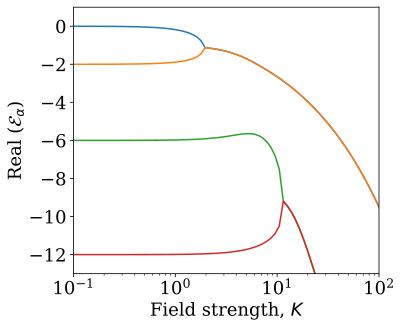

In [93]:
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_formats = ['svg']
#from wlcstat.wlcgreen import *

num_k = 100
k_val_0 = 1e-1
k_val_f = 1e3
k_val = np.logspace(np.log10(k_val_0), np.log10(k_val_f), num_k)
mu=0
dimensions = 3
num_poles = 6
#num_poles = min(12, 26-mu)
poles = np.zeros((num_k, num_poles), dtype=type(1 + 1j))
for i_k_val in range(num_k):
    poles_k_val= eval_poles(k_val[i_k_val],mu,dimensions,alpha_max=25, k_val_cutoff=1e5)
    for i_pole in range(num_poles):
        poles[i_k_val, i_pole] = poles_k_val[i_pole]

plt.figure(figsize=(6,5))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

for i_pole in range(num_poles):
    plt.semilogx(k_val, np.real(poles[:, i_pole]))

plt.xlabel(r'Field strength, $K$')
plt.ylabel(r'Real ($\mathcal{E}_{\alpha}$)')
plt.xlim(1e-1,1e2)
plt.ylim(-13,1)
plt.tight_layout()
plt.show()

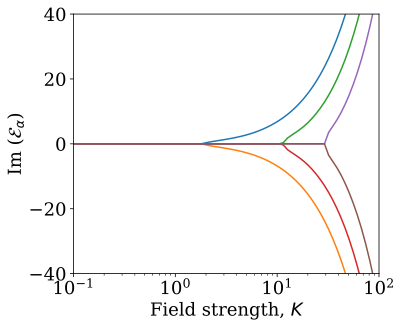

In [5]:
plt.figure(figsize=(6,5))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

for i_pole in range(num_poles):
    plt.semilogx(k_val, np.imag(poles[:, i_pole]))
    
plt.xlabel(r'Field strength, $K$')
plt.ylabel(r'Im ($\mathcal{E}_{\alpha}$)')
plt.xlim(1e-1,1e2)
plt.ylim(-40,40)
plt.tight_layout()
plt.show()

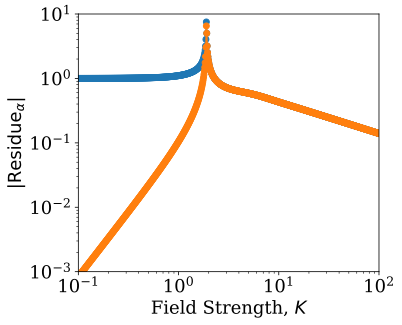

<Figure size 432x288 with 0 Axes>

In [6]:
num_k = 1000
k_val_0 = 1e-1
k_val_f = 1e3
k_val = np.logspace(np.log10(k_val_0), np.log10(k_val_f), num_k)
mu=0
dimensions = 3
num_poles = 2
#num_poles = min(12, 26-mu)
poles = np.zeros((num_k, num_poles), dtype=type(1 + 1j))
residues = np.zeros((num_k, num_poles), dtype=type(1 + 1j))
for i_k_val in range(num_k):
    poles_k_val= eval_poles(k_val[i_k_val],mu,dimensions,alpha_max=25, k_val_cutoff=1e5)
    resi_k_val = eval_residues(k_val[i_k_val], 0, poles_k_val, True, dimensions=3, lam_max=25, alpha_max=25, 
                               lam_cont_frac_max=50, k_val_cutoff=0.001)
    for i_pole in range(num_poles):
        poles[i_k_val, i_pole] = poles_k_val[i_pole]
        residues[i_k_val, i_pole] = resi_k_val[i_pole]
plt.figure(figsize=(6,5))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

for i_pole in range(num_poles):
    plt.loglog(k_val, np.real(abs(residues[:, i_pole])),'o-')

plt.xlabel(r'Field Strength, $K$')
plt.ylabel(r'$|\mathrm{Residue}_{\alpha} |$')
plt.xlim(1e-1,1e2)
plt.ylim(1e-3,1e1)
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

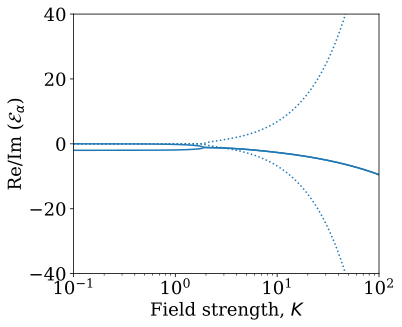

In [7]:
plt.figure(figsize=(6,5))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

for i_pole in range(num_poles):
    plt.semilogx(k_val, np.real(poles[:, i_pole]),color='C0')
    plt.semilogx(k_val, np.imag(poles[:, i_pole]),':',color='C0')
    
plt.xlabel(r'Field strength, $K$')
plt.ylabel(r'Re/Im ($\mathcal{E}_{\alpha}$)')
plt.xlim(1e-1,1e2)
plt.ylim(-40,40)
plt.tight_layout()
plt.show()